In [35]:
import os
from os import path
import cv2
from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import face_recognition as fr
from PytorchClasses import Autoencoder

In [26]:
CURRENT_DIR = path.abspath(path.curdir)
POKE_FOLDER = '/Pictures/'
CELEB_FOLDER = '/Celeb Pictures/'
poke_files = os.listdir(CURRENT_DIR + POKE_FOLDER)
celeb_files = os.listdir(CURRENT_DIR + CELEB_FOLDER)

IMG_SIZE = 50
BATCH_SIZE = 16
NUM_EPOCHS = 50
LR = 0.001

pka = pickle.load(open("pka.pkl",'rb'))
knn = pickle.load(open("knn.pkl",'rb'))

In [3]:
# Importing the pokemon autoencoder

pokencoder = Autoencoder().float()
pokencoder.load_state_dict(torch.load(CURRENT_DIR + 'PokeModel'))
pokencoder.eval()

Autoencoder(
  (Conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (Conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (Conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvTrans3): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (ConvTrans2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (ConvTrans1): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (sig): Sigmoid()
)

In [52]:
# Generating dataframe with encodings and pokemon names

names = []
og_images = []
encodings = []
knn_encodings = []

for file in tqdm(poke_files):
    
    name = file.split('.')[0]
    names.append(name)
    
    image = cv2.imread(os.path.join(CURRENT_DIR + POKE_FOLDER,file))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    og_images.append(image)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    image = np.moveaxis(image,-1,0)
    image = torch.tensor(image/255)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        encoding = pokencoder.encode(image.float())
    encoding = encoding.reshape((-1, np.prod(1600)))
    encoding = pka.transform(encoding)
    encodings.append(encoding)
    knn_encodings.append(encoding.reshape(128))
    
pokemon = pd.DataFrame({'encoding':encodings,'name':names,'og_image':og_images})#.sample(frac=1)#.reset_index(drop=True)

100%|██████████| 890/890 [00:02<00:00, 418.92it/s]


In [16]:
# Generating the Celebrity encodings

celeb_encodings = []
pokemon_encodings = []

for file in tqdm(celeb_files):
    
    celeb_image = cv2.imread(os.path.join(CURRENT_DIR + CELEB_FOLDER,file))
    try:
        celeb_encoding = fr.face_encodings(celeb_image,num_jitters=1)
    except:
        print(file)
        
    celeb_encoding = celeb_encoding[0].reshape(128)
    celeb_encodings.append(celeb_encoding)
    
    
    pokemon_name = file.split(' ')[0]
    pokemon_encoding = pokemon[pokemon["name"]==pokemon_name]["encoding"]
    try:
        pokemon_encodings.append(pokemon_encoding.values[0].reshape(128))
    except:
        print(pokemon_name)
    


    

100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


In [17]:
print(celeb_encodings[0].shape)
print(pokemon_encodings[0].shape)

(128,)
(128,)


In [102]:
linreg = LinearRegression().fit(np.array(celeb_encodings), np.array(pokemon_encodings))
pickle.dump(linreg, open("linreg.pkl","wb"))

In [25]:
print(linreg.predict(celeb_encodings[0].reshape(1,128)))
print(pokemon_encodings)

[[-3.65808716e+01 -1.84263344e+01  2.18766861e+01 -5.09306622e+00
  -1.68135667e+00 -1.08519697e+00  5.44624805e+00 -1.62197533e+01
  -1.29583588e+01  1.66927552e+00  4.98034537e-01 -2.82145071e+00
  -6.20351028e+00  1.75829053e+00 -1.95021081e+00 -1.02131081e+01
  -9.66707897e+00 -8.95650101e+00  4.56867409e+00 -2.41824913e+00
  -1.53546190e+00  8.57114911e-01  1.02466841e+01  1.29277515e+00
   2.09717131e+00 -7.39296865e+00 -5.12302399e+00  1.97582328e+00
  -4.65334034e+00 -4.24436951e+00 -2.56926870e+00  2.95763826e+00
  -2.07053351e+00 -1.06029063e-01 -1.56678355e+00  3.43213177e+00
  -1.43967843e+00  5.94271839e-01  4.52976036e+00 -8.20739627e-01
   1.68501234e+00  3.36543655e+00 -2.48470259e+00 -1.29301357e+00
   4.06304073e+00 -6.56798482e-01 -3.08366799e+00  1.96854806e+00
  -9.30485904e-01  2.26545262e+00 -3.50597501e-01 -3.41420150e+00
  -8.54289889e-01 -4.98332500e+00  5.21770239e-01 -2.81517506e-02
   2.02079415e-02 -7.23817647e-02 -2.15799880e+00 -2.98373282e-01
   1.74389

In [54]:
knn = NearestNeighbors(n_neighbors=3, metric="cosine")
knn.fit(np.asarray(knn_encodings))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [55]:
pickle.dump(knn, open("knn.pkl","wb"))

In [101]:
distances, indices = knn.kneighbors(linreg.predict(celeb_encodings[17].reshape(1,-1)))
pokemon.iloc[indices[0]]

,encoding,name,og_image
619,"[[-6.8388634, -28.763039, 37.844353, 9.696796,...",Regirock,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
156,"[[-10.007779, -25.187323, 37.323803, 4.59814, ...",Cryogonal,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
119,"[[-18.342003, -9.627646, 58.408073, -6.9075613...",Cinccino,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [103]:
pickle.dump(pokemon, open("pokedf.pkl","wb"))

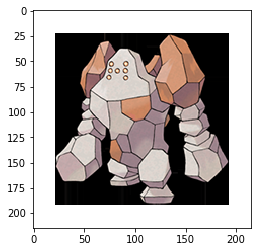

In [117]:
plt.imshow(pokemon["og_image"].iloc[619])